# Lab 2: Neural networks

In this lab we use scikit-learn to implement a simple MLP and PyTorch for a more complex neural network.

## Importing the libraries

This lab requires `h5py` package to interact with a dataset that is stored in an H5 file and the  `imageio` & `PIL` packages for image processing. If you are using the lab machines with the coms30035 Anaconda virtual environment then these are already installed. If you are using your own machine then you may need to install these packages using either pip or conda. Make sure you have all the auxiliary files (e.g. utils.py) required for this lab. The easiest way of ensuring you have all of these is just to clone the git respository.

Firstly, we'll import the required packages by running the cell below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.datasets import make_moons

import h5py
import imageio
from PIL import Image 
from utils import * # image processing functions from utils.py

## 1) Neural Network for Image Classification
In this section we are going to recap the ideas behind deep neural networks and implement a network to classify cat images (I can sense the excitement). 

The dataset we will use is a set of labeled images containing cats (label=1) and non-cats (label=0). Run the cell below to load in train and test splits of the dataset from the local `.h5` file. Make sure you have downloaded this data file in addition to the notebook from the lab repository.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
print(train_y.shape)

(1, 209)


The following cell displays an image in the dataset - change the index and re-run the cell to see other images.

y = 1. It's a cat!


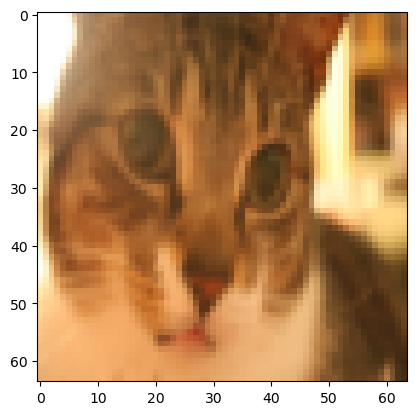

In [3]:
# Example of a cat picture
index = 200
plt.imshow(train_x_orig[index])
print (f'y = {train_y[0,index]}. It\'s a {classes[train_y[0,index]].decode("utf-8")}!')

### 1.1) Explore the dataset
Print the values of: 
- a) number of training examples (`num_train`)
- b) number of test examples (`num_test`)
- c) size of the image (height/width or the number of pixels). 

Note, `train_x_orig` is a numpy-array of shape (`num_train`, `num_px`, `num_px`, 3).

In [4]:
# write your code here

##CORRECT ANSWER##

print (f'a) number of training examples: {train_x_orig.shape[0]}')
print (f'b) number of testing examples: {test_x_orig.shape[0]}')
height = train_x_orig.shape[1]
width = train_x_orig.shape[2]
print (f'c) each image is of size: ({height}, {width})')

##CORRECT ANSWER##

a) number of training examples: 209
b) number of testing examples: 50
c) each image is of size: (64, 64)


### 1.2) Reshape the images
Reshape the training (`train_x_orig`) and test (`test_x_orig`) data sets so that each image is flattened into column vector.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

Print the shape of the reshaped training and testing datasets.

In [5]:
# write your code here

##CORRECT ANSWER##

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

print (f'train_x\'s shape: {train_x_flatten.shape}')
print (f'test_x\'s shape: {test_x_flatten.shape}')

##CORRECT ANSWER##

train_x's shape: (209, 12288)
test_x's shape: (50, 12288)


### 1.3) Standardise the images
The pixel value is a vector of three numbers (representing the RGB channels) ranging from 0 to 255. A common preprocessing step in machine learning is to standardise your dataset (subtract the mean and then divide by the standard deviation). For picture datasets, it is simpler and more convenient to apply min-max normalisation by dividing every value by 255.

Apply min-max normalization to the dataset and check the minimum and maximum are 0 and 1, respectively.

In [6]:
# write your code here

##CORRECT ANSWER##

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print (f'train_x\'s min: {train_x.min()}')
print (f'train_x\'s max: {train_x.max()}')
print (f'test_x\'s min: {test_x.min()}')
print (f'test_x\'s max: {test_x.max()}')

##CORRECT ANSWER##

train_x's min: 0.0
train_x's max: 1.0
test_x's min: 0.0
test_x's max: 1.0


### 1.4) Logistic regression classifier 
Logistic regression, despite its name, is a linear model for classification. The probabilities describing the possible outcomes of a classification are modeled using a logistic (sigmoid) function.

$$sigmoid(x) = \frac{1}{1+e^{-x}}$$

Logistic regression can be thought of as a neural network with a single node with a sigmoid activation function.

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: Logistic regression classifier.</center></caption>

Use scikit-learn's [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression) to train a cat classifier. What's the classifier's accuracy on the training and test sets?

Hint, the classifier `fit` method has the following inputs:
- Training data with shape (`n_samples`, `n_features`)
- Target values with shape (`n_samples`,). Use `.flatten()` to collapse a 2-D array to a 1-D array.

In [7]:
# write your code here

##CORRECT ANSWER##

logreg = LogisticRegression(max_iter=500)
logreg.fit(train_x, train_y.flatten())
print('Training accuracy: ', round(logreg.score(train_x, train_y.flatten()),2))
print('Testing accuracy: ', round(logreg.score(test_x, test_y.flatten()),2))

##CORRECT ANSWER##

Training accuracy:  1.0
Testing accuracy:  0.72


### Neural network architecture
We will initially build a fully connected neural network with one hidden layer (i.e. one layer between input and output). When using more than one hidden layer we define it as a deep neural network.

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: 2-layer neural network.</center></caption>
    

- ***INPUT:*** $ x = [x_0,x_1,...,x_{12287}] \quad x_i \in [0,1] $

The input is a (64,64,3) image which we have already flattened to a vector of size (12288,1) and standardised.

- ***LINEAR:*** $ z^{[1]} = W^{[1]} x + b^{[1]} $

The input vector is multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$ and then a bias term is added in a linear transformation. $n^{[1]}$ is the number of neurons in the hidden layer.

- ***RELU:*** $ a^{[1]} = RELU(z^{[1]}) = max(0,z^{[1]}) $

A non-linear activation function is then applied, in this case a rectified linear unit (or ReLU which outputs the maximum of the input and 0).

- ***LINEAR:*** $ z^{[2]} = W^{[2]} a^{[1]} + b^{[2]} $

A linear transformation is applied to the output of the hidden layer $ a^{[1]} $.

- ***SIGMOID:*** $ \hat{y} = a^{[2]} = \sigma(z^{[2]}) = \frac{1}{1 + e^{-z^{[2]}}} $

Given it's a binary classification task (cat or no cat) then the sigmoid or logistic function is the activation of the output layer (this is automatically selected by scikit-learn). 

- ***OUTPUT:*** $ \hat{y} $

The output is the probability the photo contains a cat so if the value is greater than 0.5 the prediction is cat.

The overall process from inputs to outputs is known as forward propagation, see Bishop section 5.1 for more information.

### Training a neural network
Neural networks are trained by learning the weights $W$ and biases $b$ in the hidden and output layers such that the network outputs the correct labels as optimally as possible. How well the network is performing is defined by a loss function, here the log loss (also called logistic regression loss or cross-entropy loss). The cost function $J$ which drives training is the sum of all the errors (log losses) for all the training examples in the training set.

$$ J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(\hat{y}^{(i)})+(1-y^{(i)})\log(1-\hat{y}^{(i)}) $$

The goal of neural network optimisation is to learn weights and biases that minimise the cost function. This is done by backpropagating the cost function error from the output layer, through the network to the first hidden layer. During this process the weights and biases are updated by gradient decent optimisation (using the cost function gradient with respect to all weights and bias).

For a parameter $\theta$, a simple gradient decent update rule is $ \theta = \theta - \eta \text{ } d\theta$, where $\eta$ is the learning rate (see Bishop section 5.2 and 5.3 for more information). More complex optimisation algorithms exist, for example the popular [Adam optimiser](https://arxiv.org/pdf/1412.6980).

### 1.5) Implement the neural network in scikit-learn
Thankfully, we don't need to construct the neural network manually and instead can use scikit-learn's [multi-layer perceptron (MLP) classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

Construct and train a neural network using MLP classifier with the following hyperparameters:
- Single hidden layer with 64 neurons.
- RELU activation function
- Stochastic gradient descent optimiser
- Initial learning rate $ \eta = 0.001 $ ($1e-3$)
- No regularisation $ \alpha = 0 $

Plot the loss curve (using `clf.loss_curve_`) which shows the network learning as the number of iteration increases. 

Has the loss curve flat-lined? Hint, you may have to specify the `max_iter` and `n_iter_no_change` parameters.

Text(0, 0.5, 'Loss')

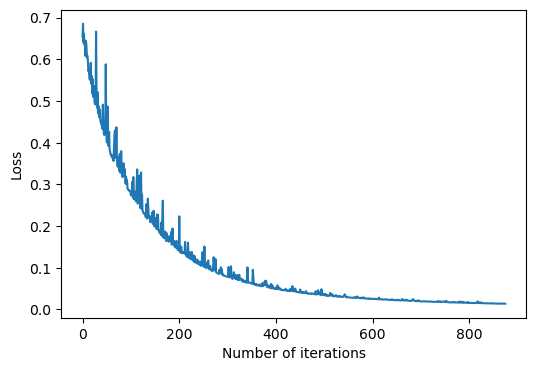

In [8]:
# write your code here

##CORRECT ANSWER##

nn_clf = MLPClassifier(hidden_layer_sizes=(64),
                    activation='relu',
                    solver='sgd',
                    alpha=0,
                    learning_rate_init=1e-3,
                    max_iter=1000,
                    n_iter_no_change=25,
                    random_state=1)
nn_clf.fit(train_x, train_y.flatten())

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(nn_clf.loss_curve_)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')

##CORRECT ANSWER##

### 1.6) Evaluation
How does the neural network perform on the training and test data? Print the training and testing accuracy. Is classifier overfitting?

A confusion matrix is a way to visualise the performance of a classification model by showing the counts of the predicted and actual labels. The following terms are important metrics in classification tasks:
- total number of positives in the dataset i.e. cat images (P)
- total number of negatives in the dataset i.e. non cat images (N)
- number of correct positive predictions (TP)
- number of correct negative predictions (TN)
- number of incorrect positive predictions (FP)
- number of incorrect negative predictions (FN)
- accuracy $= \frac{TP+TN}{P+N}$
- sensitivity, recall or true positive rate $= \frac{TP}{P}$
- specificity or true negative rate $= \frac{TN}{N}$
- precision $= \frac{TP}{TP+FP}$




Plot the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_estimator) for the test data. Where is the classifier making mistakes?

Training accuracy:  1.0
Testing accuracy:  0.76


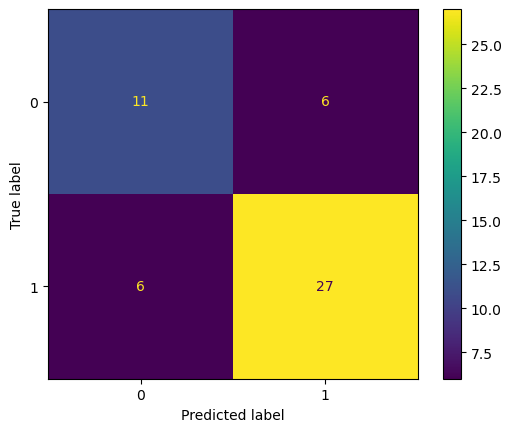

In [9]:
# write your code here

##CORRECT ANSWER##

print('Training accuracy: ', round(nn_clf.score(train_x, train_y.flatten()),2))
print('Testing accuracy: ', round(nn_clf.score(test_x, test_y.flatten()),2))

ConfusionMatrixDisplay.from_estimator(nn_clf, test_x, test_y.flatten())

##CORRECT ANSWER##          

### Hyperparameter tuning using cross-validation
The performance of a neural network after training is highly dependent on how the hyperparameters are chosen. In contrast to the network parameters, $W$ and $b$, a hyperparameter refers to something that is fixed (usually manually chosen by the person training the model) throughout training and used to control the training process. Hyperparameters include the number of hidden layers, number of neurons in the hidden layers, learning rate, mini-batch size (for stochastic gradient descent optimisers) and regularisation parameter $\alpha$.

Cross-validation (CV for short) is used to evaluate model performance for model selection and to tune hyperparameters. In k-fold CV the training set is split into k smaller sets (called folds) and each fold is used as a validation set for models trained on all the other folds.

<img src="images/kfold_cv.png" style="width:450px;height:300px;">
<caption><center> <u>Figure 3</u>: 5 fold cross validation.</center></caption>

The performance of a model is measured by the average score (error) for all the fold. A test set should still be held out for final evaluation. For more information on CV see Bishop section 1.3.

Scikit-learn offers two approaches to search the hyperparameter space using cross validation: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) which considers all parameter combinations and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) which samples a given number of candidates from a parameter space with a specified distribution.

### 1.7) Tune the learning rate and regularisation parameter using CV
The learning rate $\eta$ is an important hyperparameter to tune. Choosing a value that is too small will result in training that takes too long to converge and a value too large will cause instabilities in the training that prevent convergence. The regularisation parameter $\alpha$ controls the weighting of L2 regularisation in the cost function to help with overfitting by encouraging smaller weights leading to a smoother decision boundary.

Use RandomizedSearchCV to perform hyperparameter tuning of learning rate and regularisation parameter (limit the number of iterations `n_iter` ~10 and number of folds `cv` ~ 3 keep to reasonable training times).

A good methodology is to start with a wide range of hyperparameter values before homing in over a finer range.

Hint, use [numpy.logspace](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html) to define the range of the hyperparameters spaced over a log scale for example:
```Python
alphas = np.logspace(-3, 0, 100)
learning_rates = np.logspace(-4, -2, 100)
```

In [10]:
# write your code here

##CORRECT ANSWER##

alphas = np.logspace(-3, -0, 100)
learning_rates = np.logspace(-4, -2, 100)
parameters = {'learning_rate_init':learning_rates, 'alpha':alphas}

nn = MLPClassifier(hidden_layer_sizes=(64),
                    activation='relu',
                    solver='sgd',
                    max_iter=1000,
                    n_iter_no_change=25,
                    random_state=1)

clf = RandomizedSearchCV(nn, parameters, scoring='accuracy', n_iter=10, cv=3, verbose=2)

clf.fit(train_x, train_y.flatten())
clf.best_params_

##CORRECT ANSWER##

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END alpha=0.08111308307896872, learning_rate_init=0.0016297508346206436; total time=  15.0s
[CV] END alpha=0.08111308307896872, learning_rate_init=0.0016297508346206436; total time=  15.9s
[CV] END alpha=0.08111308307896872, learning_rate_init=0.0016297508346206436; total time=  15.9s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.003511191734215131, learning_rate_init=0.0003678379771828634; total time=  32.6s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.003511191734215131, learning_rate_init=0.0003678379771828634; total time=  31.8s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.003511191734215131, learning_rate_init=0.0003678379771828634; total time=  32.0s
[CV] END alpha=0.012328467394420659, learning_rate_init=0.008302175681319753; total time=   8.5s
[CV] END alpha=0.012328467394420659, learning_rate_init=0.008302175681319753; total time=   7.7s
[CV] END alpha=0.012328467394420659, learning_rate_init=0.008302175681319753; total time=   7.8s
[CV] END alpha=0.02009233002565047, learning_rate_init=0.0047508101621027985; total time=   9.5s
[CV] END alpha=0.02009233002565047, learning_rate_init=0.0047508101621027985; total time=   9.2s
[CV] END alpha=0.02009233002565047, learning_rate_init=0.0047508101621027985; total time=   9.6s
[CV] END alpha=0.010722672220103232, learning_rate_init=0.0006135907273413176; total time=  26.4s
[CV] END alpha=0.010722672220103232, learning_rate_init=0.0006135907273413176; total time=  27.0s
[CV] END alpha=0.010722672220103232, learning_rate_init=0.0006135907273413176; total time=  26.8s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0013219411484660286, learning_rate_init=0.000145082877849594; total time=  32.3s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0013219411484660286, learning_rate_init=0.000145082877849594; total time=  32.0s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0013219411484660286, learning_rate_init=0.000145082877849594; total time=  31.5s
[CV] END alpha=0.8697490026177834, learning_rate_init=0.0008902150854450393; total time=  24.7s
[CV] END alpha=0.8697490026177834, learning_rate_init=0.0008902150854450393; total time=  25.3s
[CV] END alpha=0.8697490026177834, learning_rate_init=0.0008902150854450393; total time=  25.9s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0013219411484660286, learning_rate_init=0.0004229242874389499; total time=  31.6s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0013219411484660286, learning_rate_init=0.0004229242874389499; total time=  31.6s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0013219411484660286, learning_rate_init=0.0004229242874389499; total time=  32.5s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.021544346900318846, learning_rate_init=0.00023101297000831605; total time=  32.9s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.021544346900318846, learning_rate_init=0.00023101297000831605; total time=  31.7s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.021544346900318846, learning_rate_init=0.00023101297000831605; total time=  31.6s
[CV] END alpha=0.0016297508346206436, learning_rate_init=0.00628029144183426; total time=   8.8s
[CV] END alpha=0.0016297508346206436, learning_rate_init=0.00628029144183426; total time=   8.9s
[CV] END alpha=0.0016297508346206436, learning_rate_init=0.00628029144183426; total time=   8.5s


/home/uw20605/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


{'learning_rate_init': 0.00023101297000831605, 'alpha': 0.021544346900318846}

It is common to create deep networks for most tasks with complexity controlled not by the network size (number of layers and nodes per layer) but with regularisation. Regularisation is a general term describing ways to control the complexity of a neural network in order to avoid overfitting. We have already discussed (and tuned) the L2 regularisation term of the error function.

Dropout is another regularisation technique and has been shown as an effective way of preventing overfitting but is unfortunately not implemented scikit-learn MLP. For dropout it's recommended to use either the [PyTorch](https://pytorch.org/tutorials/) or [TensorFlow/Keras](https://www.tensorflow.org/tutorials) frameworks which offer far more flexibility in neural network architectures as opposed to scikit-learn and faster training on GPUs.

Can you improve the performance of the network by tuning the various hyperparameters?

### 1.8) Just for fun, test your classifier with your own image
Upload a photo into the images folder and change the `my_image` variable in the cell below.

/tmp/ipykernel_40363/1008196007.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))


Your neural network predicts a cat picture.


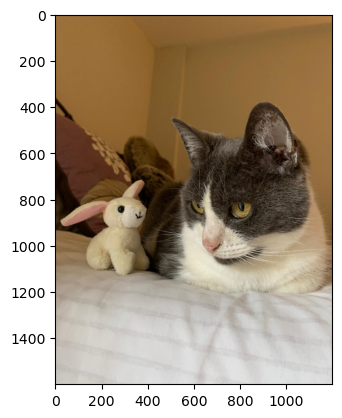

In [11]:
my_image = "cat.jpg" # change this to the name of your image file 

fname = "images/" + my_image
image = np.array(imageio.imread(fname))
my_image = np.array(Image.fromarray(image).resize((height,width))).reshape((-1,1))
my_image = my_image/255.
my_predicted_image = nn_clf.predict(my_image.T)

plt.imshow(image)
print ("Your neural network predicts a " + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  " picture.")

## 2) Using PyTorch for Image Classification

Go to the [Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html) PyTorch introduction. Read through the various sections of this introduction, except that you can skip Section 0 "Quickstart" and Section 7 "Save, Load and Use Model". You can 'skim read' most sections but the Sections "Build the Neural Network" and "Optimizing Model Parameters" should be read properly. Note that for each section you can download the assocated Jupyter notebook by using the "Download Notebook" icon at the top of the page.

### 2.1) Running PyTorch

Download and run the notebook for the "Optimizing Model Parameters" section. Make sure you know what's going on.

### 2.2) Logistic regression

Alter the neural network so that it is just doing logistic regression. You should do this by altering the `__init__` method of the `NeuralNetwork` class appropriately. Leave all hyperparameters the same and do learning with this simplifed network (just re-run your edited notebook). Compare the test set accuracy you get with that achieved by the original network.

In [12]:
##CORRECT ANSWER##

def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #nn.Linear(28*28, 512),
            #nn.ReLU(),
            #nn.Linear(512, 512),
            #nn.ReLU(),
            nn.Linear(28*28, 10),
        )

##CORRECT ANSWER##

### 2.3) Improving accuracy

Find a way of improving the (test set) accuracy of both the original network and the network which implements logistic regression. Feel free to experiment!

##CORRECT ANSWER##
Just increasing the number of training epochs will help in both cases. No doubt there are many other alterations that would help.
##CORRECT ANSWER##

### 2.4) Using dropout

Apply [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) to the input layer of the (original) network using a probability of dropout of 0.2. You can do this by adding the following line of code to your `__init__` method: `self.dropout = nn.Dropout(0.2)` and then altering your `forward` method appropriately. Does dropout help? Explain why it helps or does not help.

In [13]:
##CORRECT ANSWER##
def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(x)
        logits = self.linear_relu_stack(x)
        return logits
##CORRECT ANSWER##

##CORRECT ANSWER##
Dropout does not seem to help here (in all experiments I have done anyway). This is probably since there does not seem to be a problem of overfitting, at least if training is restricted to not too many epochs.
##CORRECT ANSWER##

## Wrap up

This lab has covered quite a bit, let's recap:
- We built a fully-connected neural network to classify cats and achieved a test set accuracy of over 70% even before hyperparameter tuning. Note that in the field of computer vision it is common to use convolutional neural network (CNN) architectures instead of fully-connected networks since they show superior performance for image classification. A randomised search cross validation method was presented for hyperparameter tuning although automatic tuning using [Bayesian optimisation](https://arxiv.org/abs/1206.2944) can produce better results in less time.
- We've also explored using PyTorch, again for image classification. We have compared with logistic regression and experimented with using dropout.

### References
- Bishop Pattern Recognition and Machine Learning: chapter 5 for neural networks. 

#### Materials used to create the lab
- University of Edinburgh's Machine Learning and Pattern Recognition (MLPR) course
- Andrew Ng's Neural Networks and Deep Learning course on Coursera
